# Chapter 3 - notebook level 0

### Save velocity (U,V) and sediment (C) data for all Signature ADCP files at 5 min time step

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import natsort

# from d2spike.despike import DataArray
# from wootils.plotnice import vert_stack
from pIMOS.utils.nortek_signature_utils import beam2inst, inst2earth

import sys
sys.path.insert(0, '../')
from chp3_despike import full_pipe
# from chp3_basefuncs import get_sigfiles
# from chp3_fluxfuncs import  get_nliw_times

import warnings
warnings.filterwarnings("ignore")

pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp


In [2]:
moor = 'L150'
field_trip = 'RS19'

## Specify the files

In [3]:
# Set key data directories
nc_dir = r'/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/'
nc_files = glob.glob(os.path.join(nc_dir, f'*{moor}*Signature*.nc'))

# Files need natural sorting!!!
nc_files = natsort.natsorted(nc_files)
nc_files

['/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[0of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[1of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[2of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[3of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[4of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[5of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signature 1000]_[100460]_[6of59].nc',
 '/mnt/share/Experiments/rs19/archive_FV00/Signature 1000/[RS2019]_[RS19_REC]_[L150]_[28]_[Signat

In [4]:
save_dir = r'/mnt/c/Users/00099894/Large_Data/RS2019'
save_dir = os.path.join(save_dir, 'all_deployment')
os.makedirs(save_dir, exist_ok=True)

In [5]:
sig_full = os.path.join(nc_dir, nc_files[0])
ds1 = xr.open_dataset(sig_full)

In [6]:
ds1

<xarray.Dataset>
Dimensions:                   (beam: 5, height: 254, time: 151221,
                               cartesian_axes: 3)
Coordinates:
  * beam                      (beam) int32 1 2 3 4 5
  * cartesian_axes            (cartesian_axes) int32 1 2 3
  * height                    (height) float64 0.1 0.13 0.16 ... 7.63 7.66 7.69
  * time                      (time) datetime64[ns] 2019-03-05T00:00:00.06329...
    lat_nom                   float64 ...
    lon_nom                   float64 ...
    z_nom                     float64 ...
Data variables: (12/21)
    vel_dolfyn                (beam, height, time) float32 ...
    vel_enu                   (cartesian_axes, height, time) float32 ...
    vel_xyz                   (cartesian_axes, height, time) float32 ...
    four_beam_error_velocity  (height, time) float64 ...
    pressure                  (time) float32 ...
    temperature               (time) float32 ...
    ...                        ...
    qc_velocity               (beam, height, time) float32 ...
    qc_velocity3              (cartesian_axes, height, time) float64 ...
    qc_temperature            (time) float32 ...
    qc_pressure               (time) float32 ...
    qc_compass                (time) float32 ...
    qc_tilt                   (time) float32 ...
Attributes: (12/33)
    title:                           Measured data from a Nortek Signature
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          Nortek Signature ADCP
    project:                         RS2019
    history:                         
    ...                              ...
    nominal_site_depth:              150.0
    pressure_sensor_height_asb:      
    nominal_instrument_height_asb:   0.29
    nominal_instrument_orientation:  
    timezone:                        UTC
    is_profile_data:                 0

In [7]:
slu = 5.5
sld = 4.5
win = 300

In [8]:
# Loop through files
for ixll, file in enumerate(nc_files):
    print(ixll)
    if ixll>-1:
    
        # Load Signature file
        ds = xr.open_dataset(file)
        xr.Dataset.close(ds1)

        # Copy out the new data array to fill
        tstep = (ds['time'].values[1] - ds['time'].values[0]) / np.timedelta64(1, 's')
        winint = int(win/tstep)

        vel_east = ds['vel_enu'].sel(cartesian_axes=1, height=slice(sld, slu)).copy()
        vel_east_mean = vel_east.rolling(time=winint, center=True).mean().mean(dim='height')[::winint]

        vel_nort = ds['vel_enu'].sel(cartesian_axes=2, height=slice(sld, slu)).copy()
        vel_nort_mean = vel_nort.rolling(time=winint, center=True).mean().mean(dim='height')[::winint]

        echo = ds['echo'].sel(beam=5, height=slice(sld, slu)).copy()
        echo_mean = echo.rolling(time=winint, center=True).mean().mean(dim='height')[::winint]

        ds_pos = ds[['heading', 'pitch', 'roll']].rolling(time=winint, center=True).mean()\
            .isel(time=np.arange(0, len(ds.time), winint))

        # Append to each array on each loop
        if ixll==0:
            vel_east_mean_all = vel_east_mean
            vel_nort_mean_all = vel_nort_mean
            echo_mean_all = echo_mean
            ds_pos_all = ds_pos
        else:
            vel_east_mean_all = xr.concat([vel_east_mean_all, vel_east_mean], dim='time')
            vel_nort_mean_all = xr.concat([vel_nort_mean_all, vel_nort_mean], dim='time')
            echo_mean_all = xr.concat([echo_mean_all, echo_mean], dim='time')
            ds_pos_all = xr.concat([ds_pos_all, ds_pos], dim='time')
            

# Create final dataset
echo_mean_all = echo_mean_all.squeeze()
vel_horz = xr.concat([vel_east_mean_all, vel_nort_mean_all], dim='cartesian_axes')
ds_new = xr.merge([vel_horz, echo_mean_all, ds_pos_all['heading'], ds_pos_all['pitch'], ds_pos_all['roll']],\
                  compat='override')

# Save as netcdf
ds_new.to_netcdf(path=('SIG_meandataENU.nc'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


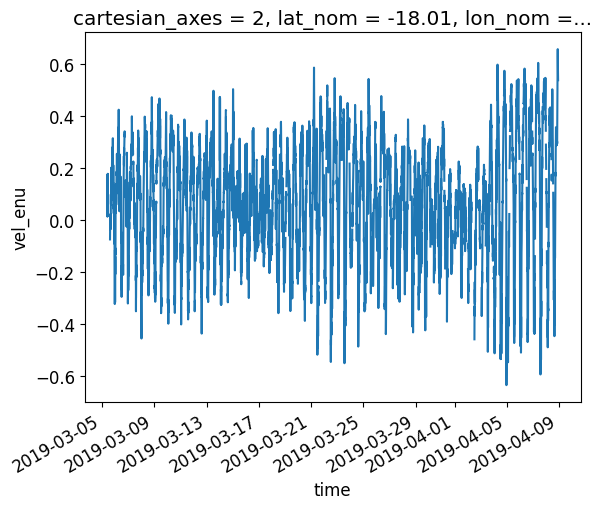

In [11]:
ds_new['vel_enu'].isel(cartesian_axes=1).plot()